In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
import os
import pickle
from scipy import stats
import random

In [ ]:
embeddings_path = "../../data/embeddings/embeddings/"
models = ["facenet","arcface"]
attributes = ['0','1','2','3','4','brightness', 'contrast', 'hue']
max_curves = 5*10**3 # Number of curves to be sampled

energy = {m:[] for m in models}

# Precompute necessary quantities
metadata = pd.read_csv(os.path.join(embeddings_path,"df_param_step.csv")) 
metadata = metadata.assign(moving_dimension=lambda x: x['moving_dimension'].astype("str")) # Fix problem in metadata
metadatas = {dim: metadata.loc[metadata["moving_dimension"]==dim] for dim in attributes} # Filter the metadas for each attribute
ids_curves = {dim:np.unique(metadatas[dim]["id_curve"].values) for dim in attributes} 
for dim in ids_curves.keys():
    random.shuffle(ids_curves[dim])

# Sample the curves
adfs = {dim: metadatas[dim][metadatas[dim]["id_curve"].isin(ids_curves[dim][:max_curves])].sort_values("id_curve") for dim in attributes}

# Compute the indices of the emebeddings
adfs_0 = {dim: adfs[dim][adfs[dim]["param_step"]==0]["index"].values for dim in attributes}
adfs_1 = {dim: adfs[dim][adfs[dim]["param_step"]==1]["index"].values for dim in attributes}
adfs_2 = {dim: adfs[dim][adfs[dim]["param_step"]==2]["index"].values for dim in attributes}

for m in models:
    print("MODEL: ", m)
    for p in tqdm(os.listdir(embeddings_path+m+"/")): # iterate over identities
        if p.split(".")[1] == "npy":
            # Load embeddings
            embeddings = np.load(os.path.join(embeddings_path+m+"/",p))
            en = []
            for dim in attributes:

                embs_pc = embeddings[adfs_1[dim],:] # point cloud
                vf_pc = embeddings[adfs_2[dim],:] - embeddings[adfs_0[dim],:] # vector field (3 point stencil)
                vf_pc = (vf_pc.T/np.linalg.norm(vf_pc, axis = 1)).T # normalize vector field
                
                # Compute distance matrix
                if m == "facenet":
                    D_mat = euclidean_distances(embs_pc)
                else:
                    D_mat = cosine_distances(embs_pc)

                D_mat[D_mat==0] = np.inf
                inv_D_mat = np.nan_to_num(1/D_mat, posinf = 0)
                D_mat_vf = cosine_distances(vf_pc) # Compute cosine distances between point clouds
                
                en.append(np.mean(np.sum(inv_D_mat*D_mat_vf,1)/np.sum(inv_D_mat,1)))
        
            energy[m].append(en)



/var/folders/f6/5t2dxw1n72nf__cgdxs0x8m80000gn/T/ipykernel_6597/4290545253.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(os.path.join(folder_path,"df_param_step.csv"))


MODEL:  facenet


100%|██████████| 40/40 [04:35<00:00,  6.90s/it]


MODEL:  arcface


100%|██████████| 40/40 [03:49<00:00,  5.73s/it]


Save energies

In [ ]:
with open('../../data/results/gan_control_energies_all_models_5k.pickle', 'wb') as handle:
    pickle.dump(energy, handle, protocol=pickle.HIGHEST_PROTOCOL)

Plot results

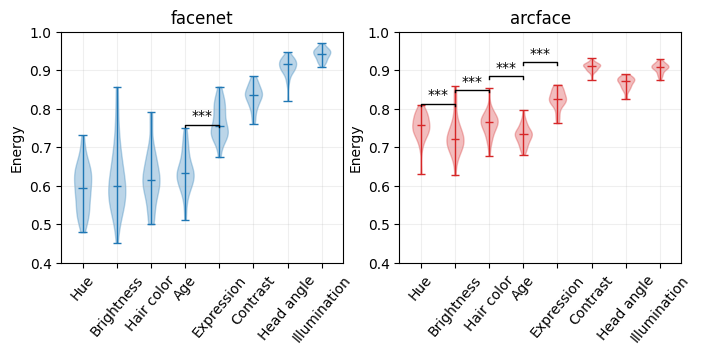

In [ ]:
energy = {m:np.array(energy[m]) for m in list(energy.keys())}
features = ["Head angle", "Age", "Hair color", "Illumination", "Expression"] + ['Brightness', 'Contrast', 'Hue']
frange = list(range(1,len(features)+1))

#perm = [1,2,4,0,3]
perm = [7,5,2,1,4,6,0,3]

features = [features[i] for i in perm]

f,ax = plt.subplots(1,2,figsize = (8,3))

for im,m in enumerate(models):

    vlpt = ax[im].violinplot(energy[m][:,perm], showmedians = True, 
                        )#quantiles = [[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75]]);

    c = "tab:blue" if m == "facenet" else "tab:red"
    for pc in vlpt['bodies']:
        pc.set_facecolor(c)
        pc.set_edgecolor(c)

    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = vlpt[partname]
        vp.set_edgecolor(c)
        vp.set_linewidth(1)

    ax[im].set_xticks(ticks=frange,labels = features, rotation = 50);
    ax[im].set_ylabel("Energy")
    ax[im].set_title(m)
    #plt.hlines(1,0.5,5.5,color = "black", label = "Random")

    ax[im].grid(alpha = 0.2)


    significant_combinations = []
    # Check from the outside pairs of boxes inwards
    ls = list(range(0, 5))
    combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
    combinations = [(1,2),(2,3),(3,4),(4,5)]
    energy2 = energy[m][:,perm]
    for combination in combinations:
        data1 = energy2[:,combination[0] - 1]
        data2 = energy2[:,combination[1] - 1]
        # Significance
        U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
        if p < 0.05:
            significant_combinations.append([combination, p])

    bottom, top = 0.4,1

    ax[im].set_ylim([bottom,top])

    y_range = top - bottom

    for i, significant_combination in enumerate(significant_combinations):
        # Columns corresponding to the datasets of interest
        x1 = significant_combination[0][0]
        x2 = significant_combination[0][1]
        # What level is this bar among the bars above the plot?
        level = 0.5*len(significant_combinations) - (5-i)
        # Plot the bar
        bar_height = (y_range * 0.06 * level) + top-0.08
        bar_tips = bar_height - (y_range * 0.01)
        ax[im].plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
        )
        # Significance level
        p = significant_combination[1]
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
        text_height = bar_height + (y_range * 0.01)
        ax[im].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')


#plt.legend(loc = "lower right")

#plt.savefig("arcface_control_cos.pdf")

#plt.hlines(0,0.5,5.5,color = "gray")
